# Attitude determination

## august campaign

### load data from logs

In [1]:
indir="/home/limu/Lab/Alpha/station/processed_jr/"
date='2021-08-10'
import os
import pandas as pd
#aug1=pd.read_csv(indir+date+'/hk_data_decoded.txt',delimiter='\t')
aug1=pd.read_csv("/home/limu/Space/logs/alpha/hk_data_august_last.txt",delimiter='\t')
aug1.columns

Index(['RealTimeStamp', 'DK EpochTimeStamp [s]', 'DK TimeStamp', 'CunkID',
       'ChunkType', 'Length [B]', 'LdSt magX [nT]', 'LdSt magY [nT]',
       'LdSt magZ [nT]', 'LdStTot [nT]', 'OBC magX [nT]', 'OBC magY [nT]',
       'OBC magZ [nT]', 'OBCtot [nT]', 'OBC_9DOF_Temp [*C]',
       'OBCgyroX [deg/s]', 'OBCgyroY [deg/s]', 'OBCgyroZ [deg/s]',
       'OBCaccX [mG]', 'OBCaccY [mG]', 'OBCaccZ [mG]', 'SolT X+ [*C]',
       'SolT Y+ [*C]', 'SolT X- [*C]', 'SolT Y- [*C]', 'SolT Z- [*C]',
       'OBC_Temp [*C]', 'ssTemp(X+) [*C]', 'ssTemp(Y+) [*C]',
       'ssTemp(X-) [*C]', 'ssTemp(Y-) [*C]', 'ssTemp(Z-) [*C]', 'ssIRRad(X+)',
       'ssIRRad(Y+)', 'ssIRRad(X-)', 'ssIRRad(Y-)', 'ssIRRad(Z-)',
       'ssAngleX (X+) [deg]', 'ssAngleY (X+) [deg]', 'ssAngleX (Y+) [deg]',
       'ssAngleY (Y+) [deg]', 'ssAngleX (X-) [deg]', 'ssAngleY (X-) [deg]',
       'ssAngleX (Y-) [deg]', 'ssAngleY (Y-) [deg]', 'ssAngleX (Z-) [deg]',
       'ssAngleY (Z-) [deg]', 'ssGyroX (X+) [deg/s]', 'ssGyroY (X+) [deg/s

In [2]:
mok=aug1
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
from datetime import datetime,timedelta
mags=np.array([np.array(mok[mok.columns[6+i]]) for i in range(3)]).T
mags=mags[1:-1]

In [55]:
irpos=[i for i in range(len(mok.columns)) if mok.columns[i].find("IRR")>0]
rep=[]
qth = (48.7408,-21.2284,380)
from astropy import coordinates as coord
from astropy import units as u
import predict
tle= """GRBALPHA                
1 47959U 21022AD  22063.19213865  .00002067  00000+0  14319-3 0  9994
2 47959  97.5413 324.9761 0022167 141.3192  11.3230 15.06545409 50965"""
pars=['longitude','latitude','altitude','epoch']
kosice=coord.EarthLocation.from_geodetic(qth[1],-qth[0],qth[2])#,unit=(u.degree, u.degree,u.meter))
kosrad=np.sqrt(sum(np.array(kosice.value.tolist())**2))*1e-3 #earth distance in km

for d in mok['DK TimeStamp']:
    x=datetime.strptime(d,"%d-%m-%Y %H:%M:%S")
    y=predict.observe(tle, qth, at=x.timestamp())
    rep.append([y['longitude'],y['latitude'],y['altitude']])
rep=np.array(rep).T
if rep[0].max()-rep[0].min()>200:rep[0]=(rep[0]+180)%360-180
len(rep[0])

36

In [5]:
from periodogram import get_mag_dir

pomag=[]
for i in [0,len(rep)-1]:
    day=mok['DK TimeStamp'][i].split(' ')[0]
    day='-'.join(day.split('-')[::-1])
    pomag.append(get_mag_dir(day,rep[1][i],rep[0][i],rep[2][i]))
    
pom1,pom2=pomag[0],pomag[-1]
vecs=[np.array([dic[t+'-intensity'] for t in ['east','north','vertical']]) for dic in pomag]#'declination'] 
norm=lambda v:np.sqrt(np.dot(v,v))
nvecs=[v/norm(v) for v in vecs]
nvecs

[array([-0.30966762,  0.22617738, -0.92355279]),
 array([-0.30946851,  0.22846707, -0.92305582])]

In [86]:
#datetime.strptime?
from datetime import timezone
times[0]

datetime.datetime(2021, 8, 10, 9, 53, 37)

In [87]:
satcoor2=[coord.EarthLocation.from_geodetic(r[0],r[1],r[2]*1e3) for r in rep.T] 
times=[datetime.strptime(m,"%d-%m-%Y %H:%M:%S") for m in mok['DK TimeStamp']]
len(times)

TypeError: strptime() takes exactly 2 arguments (3 given)

In [7]:
from imp import reload
import periodogram as pg
reload(pg)

<module 'periodogram' from '/home/limu/Code/Notebook/Astro/cube/periodogram.py'>

In [8]:
sunvec_hall=np.array([pg.sun_vec_CHall(t) for t in times])
#some "eye" estimate
irvec=np.array([[0,-0.9,np.sqrt(0.19)],[-0.9/np.sqrt(2),-0.9/np.sqrt(2),np.sqrt(0.19)],[-0.8,-np.sqrt(0.17),np.sqrt(0.19)],])

In [9]:
all_rot=[]
from satutils import triad
dt=np.array([(t-times[0]).seconds for t in times])
dtot=dt[-1]
magdir=[coord.SkyCoord(pomag[i]['inclination'],pomag[i]['declination'],unit="deg",frame="altaz",location=satcoor2[i],obstime=times[i]) for i in [0,-1]]
magvec=[np.array([c.x.value,c.y.value,c.z.value]) for c in [m.fk5.cartesian for m in magdir]]
magvec=[m/norm(m) for m in magvec]
mag_inter = lambda t:(t/dtot*magvec[1]+(1-t/dtot)*magvec[0])

for i in [0,1,2]:
    t_body=triad(mags[i]/norm(mags[i]),irvec[i]) #body frame
    t_equa=triad(mag_inter(dt[i]),sunvec_hall[i]) #ra dec frame
    #rot_body_equa=t_equa.T@t_body
    all_rot.append(t_equa.T@t_body)


In [53]:
len(rep[0]),len(times)

(36, 48)

In [81]:
print(np.array([sunvec_hall[i] for i in [1,10,-1]])) # in ECI
#from astropy.coordinates import get_body_barycentric, get_body, get_sun, EarthLocation
from astropy.time import Time
sunvec_apy=[coord.get_sun(Time(t)) for j,t in enumerate(times)]
for j,s in enumerate(sunvec_apy):
    s.location=coord.EarthLocation(rep[0][j],rep[1][j])
    #print(rep[0][j],rep[1][j])
import satutils as su
sunvec_loc=[su.fromangle(s.altaz.az.value,s.altaz.alt.value) for s in sunvec_apy]
sunvec_eci=[su.fromangle(s.fk5.ra.value,s.fk5.dec.value) for s in sunvec_apy]
np.array([sunvec_eci[i] for i in [1,10,-1]])

[[-0.89130227  0.41600404  0.18033554]
 [-0.89130385  0.41600119  0.18033431]
 [-0.8913092   0.41599153  0.18033012]]


array([[-0.87017757,  0.4453463 ,  0.21084985],
       [-0.87017768,  0.44534614,  0.21084979],
       [-0.87017802,  0.44534557,  0.21084956]])

In [91]:
j=-1
coo=coord.AltAz(0*u.deg,-90*u.deg,obstime=times[j], location=satcoor2[j])
coo.obstime.location=coo.location
tm=coo.obstime.sidereal_time('mean')
sco=coord.SkyCoord(coo)#,frame='altaz')
sco.icrs, rep[:,j],tm.deg,sco.separation(sunvec_apy[j]).deg

(<SkyCoord (ICRS): (ra, dec) in deg
     (342.33223869, 49.51381572)>,
 array([ 54.7239995 , -49.62588829, 584.03958974]),
 162.57333705369138,
 112.06091226692243)

In [10]:
## prediction of Sun direction in body frame?

[all_rot[i].T@sunvec_hall[i] for i in range(3)]

[array([ 0.5306887 , -0.7408788 , -0.41166505]),
 array([-0.86491932, -0.07052946, -0.49666964]),
 array([-0.8969679 ,  0.34277965, -0.27844073])]

### finding proper sun direction

- fix the magnetic field direction
- est. angle between sun and magnet
- vary "azimuth" of sun vector to fit best the observation

In [11]:
angle=[np.arccos(np.dot(mag_inter(dt[i]),sunvec_hall[i])) for i in range(len(dt))]
#pl.plot(np.rad2deg(angle))
angle=np.mean(angle) #changes negligeable

In [14]:
mbody=[m/norm(m) for m in mags]
phi=np.r_[:2*np.pi:40j]
j=3
wee=np.array([np.cos(angle),np.sin(angle)*np.cos(phi[j]),np.sin(angle)*np.sin(phi[j])])
rmatx=triad(mbody[j],[0,0,1])
sun_ex=rmatx.T@wee
np.arccos(np.dot(sun_ex,mbody[j]))

1.6580767401861936

[[<matplotlib.lines.Line2D at 0x7f55a8dfb610>],

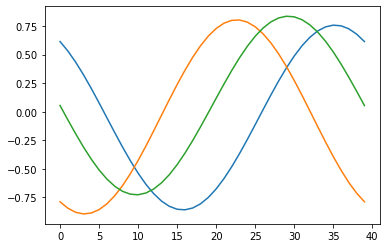

In [15]:
#np.allclose(rmatx.T@rmatx,np.eye(3)) # rmatx is orthonormal
awee=np.array([np.cos(angle)*np.ones_like(phi),np.sin(angle)*np.cos(phi),np.sin(angle)*np.sin(phi)])
asun=rmatx.T@awee # in body frame
[pl.plot(s) for s in asun]

### try some model

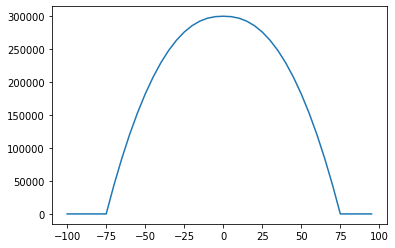

In [16]:
amp=3e5
mang=75
zex=2.3
viewang=lambda ang:(abs(ang)<mang)*(1-(abs(ang)/mang)**zex)*amp
angs=np.r_[-100:100:5]
pl.plot(angs,[viewang(a) for a in angs])

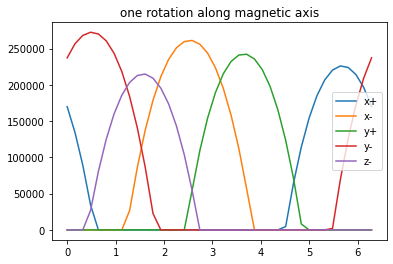

In [17]:
xp,xm=viewang(np.rad2deg(np.arccos(asun[0]))),viewang(180-np.rad2deg(np.arccos(asun[0])))
yp,ym=viewang(np.rad2deg(np.arccos(asun[1]))),viewang(180-np.rad2deg(np.arccos(asun[1])))
zm=viewang(180-np.rad2deg(np.arccos(asun[2])))
pl.plot(phi,xp,phi,xm)
pl.plot(phi,yp,phi,ym)
pl.plot(phi,zm)
pl.title("one rotation along magnetic axis")
pl.legend("x+ x- y+ y- z-".split())

In [18]:
tle_all=open("/home/limu/Code/Notebook/Astro/alpha/ephem/tle_all.txt").readlines()
tle_arr=[tle_all[4*i+1].replace('-','.').replace('+','.').split()[3:]+tle_all[4*i+2].replace('-','.').split()[2:] for i in range(len(tle_all)//4)]

In [19]:
tle_grb=''.join([t[30:] for t in tle_all[-3:]])
tle_pre=''.join([t[30:] for t in tle_all[-7:-4]])

print(tle_pre)
print(tle_grb)

GRBALPHA                
1 47959U 21022AD  22047.50776378  .00003147  00000+0  21647-3 0  9996
2 47959  97.5424 309.6188 0020571 194.7841 268.3098 15.06467169 48600

GRBALPHA                
1 47959U 21022AD  22063.19213865  .00002067  00000+0  14319-3 0  9994
2 47959  97.5413 324.9761 0022167 141.3192  11.3230 15.06545409 50965



In [20]:
tle_grb=''.join([t[30:] for t in tle_all[-3:]])
tle_grb='''GRBALPHA
1 47959U 21022AD  22089.06574127  .00004075  00000-0  27671-3 0  9996
2 47959  97.5376 350.3030 0022746  59.5456 300.8062 15.06733026 54867'''
now=datetime.now()
trans=predict.transits(tle_grb,qth,now.timestamp(),(now+timedelta(0,1e6)).timestamp())
trans=[t for t in trans if t.peak()['elevation']>10]

In [21]:
from datetime import timezone#.utc as utc
timezone.utc
#now.tzinfo
#timezone.timezone('Europe/Prague')
t=trans[2]
datetime.fromtimestamp(t.start,timezone.utc)#.tzinfo

datetime.datetime(2022, 4, 9, 7, 11, 32, 181845, tzinfo=datetime.timezone.utc)

In [22]:
times=[[datetime.fromtimestamp(tx,timezone.utc).isoformat()[:19].replace('T',' ') for tx in [t.start,t.peak()['epoch'],t.end]] for t in trans]

In [23]:
gpos=lambda p:[p["longitude"],p["latitude"]]
zpos=[gpos(t.peak()) for t in trans]
zpos[:10]

[[20.88185210963427, 48.79933089545054],
 [359.46753283416007, 54.7542111661859],
 [43.00098281318359, 54.87815791833698],
 [21.639390217526024, 48.80952676373824],
 [22.198486066066284, 48.585744615092615],
 [0.6456174670262704, 54.28502977181211],
 [22.952426189903864, 49.03681092185637],
 [359.6445640321501, 47.406073416543265],
 [23.523841590537486, 48.38906510638121],
 [1.8370057825832418, 53.83148844790512]]

### statistics of other HK data

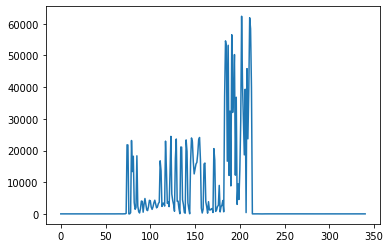

In [24]:
set1=np.loadtxt("/home/limu/Space/logs/sun_columns_s1.txt").T
set2=np.loadtxt("/home/limu/Space/logs/sun_columns_s2.txt").T
aset=np.r_[set1]
pl.plot(aset[:,0])

Text(0.5, 1.0, 'X-axis')

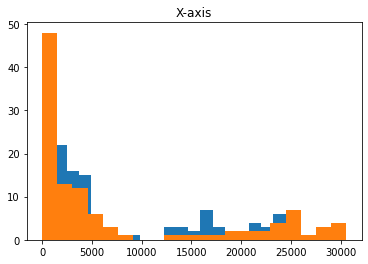

In [26]:
ssel=aset[:,0]*aset[:,1]>200
pl.hist(aset[ssel,0],20);
pl.hist(aset[ssel,2],20);
pl.title('X-axis')

Text(0.5, 1.0, 'Y-axis')

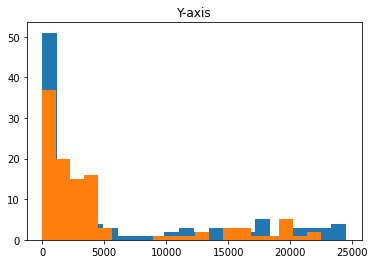

In [27]:

pl.hist(aset[ssel,1],20);
pl.hist(aset[ssel,3],20);
pl.title('Y-axis')

Text(0.5, 1.0, 'Z-axis')

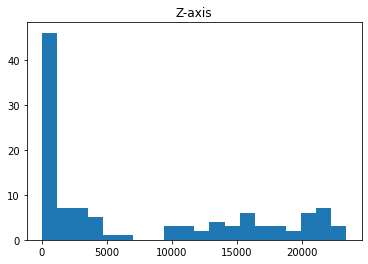

In [28]:
pl.hist(aset[ssel,4],20);
pl.title('Z-axis')

In [29]:
#aset[aset[:,4]>35000,4]
np.where(aset[:,4]>35000)[0]
aset[206]

array([39348.,     0.,  1890.,     0., 50368.])

In [42]:
def get_perc(x,pval=[10,90],xmin=7000):
    xsel=x>xmin
    return np.percentile(x[xsel],pval)
irnorm=np.array([get_perc(s[ssel]) for s in aset.T])
import pickle
pickle.dump(irnorm,open("coramp.pkz","wb"))
#irnorm

[[<matplotlib.lines.Line2D at 0x7f55a8a00c10>],

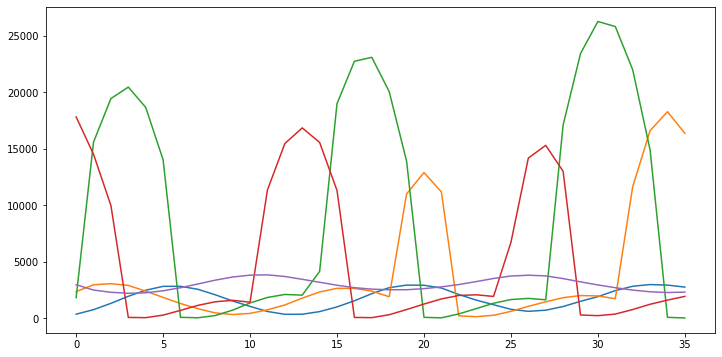

In [31]:
fig=pl.figure(figsize=(12,6))
irsens=np.array([mok[c].to_numpy() for c in [mok.columns[i] for i in irpos]])

[pl.plot(s) for s in irsens]

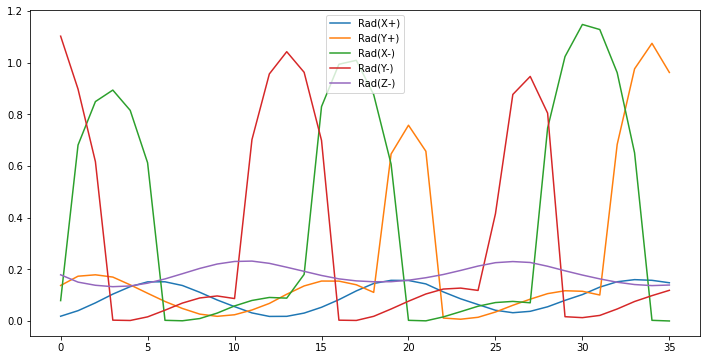

In [32]:
irsens2=irsens*2/(irnorm[:,0]+irnorm[:,1])[:,np.newaxis]
fig=pl.figure(figsize=(12,6))
[pl.plot(s) for s in irsens2]
pl.legend([mok.columns[i][4:] for i in irpos])

### rotating model vs. reality

Text(0, 0.5, 'simulated')

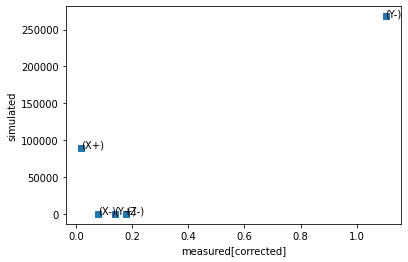

In [33]:
labels=[mok.columns[i][7:] for i in irpos]
simu=np.array([xp,yp,xm,ym,zm])
k=0
pl.plot(irsens2[:,k],simu[:,2],'s')
for i in range(5):
    pl.text(irsens2[i,k],simu[i,2],labels[i])
np.corrcoef(irsens2[:,k],simu[:,2])[0][1]
pl.xlabel("measured[corrected]")
pl.ylabel("simulated")
#pl.plot(phi,xp,phi,xm)
#pl.plot(phi,yp,phi,ym)
#pl.plot(phi,zm)

Text(0, 0.5, 'correl.coef')

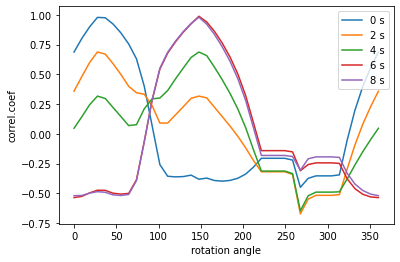

In [92]:

for k in [0,1,2,3,4]:
    prof1=[np.corrcoef(irsens2[:,k],s)[0][1] for s in simu.T]
    pl.plot(phi/np.pi*180,prof1,label=str(2*k)+" s")
pl.legend()
pl.xlabel("rotation angle")
pl.ylabel("correl.coef")

Text(0.5, 1.0, 'diff')

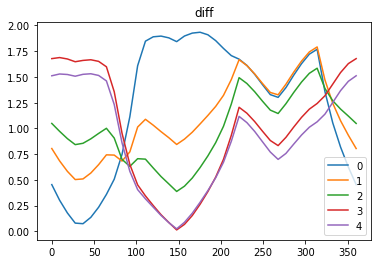

In [35]:
for k in [0,1,2,3,4]:
    prof2=[np.sum((irsens2[:,k]-s/amp)**2) for s in simu.T]
    pl.plot(phi/np.pi*180,prof2,label=k)
pl.legend()
pl.title("diff")

In [97]:
simu.max(0)

array([229585.22600304, 249463.96510476, 261370.85069158, 265924.74412162,
       263432.25591248, 253719.46472899, 236231.6805031 , 210278.70779388,
       214662.34798433, 224052.79034643, 225914.80366142, 220312.36414279,
       207059.64109214, 226378.26613382, 242784.32982871, 251627.7690079 ,
       253306.1025026 , 247906.17314989, 235162.49963944, 214576.89156631,
       224611.74948921, 241244.23721558, 249896.98646299, 250983.04513406,
       244560.9209403 , 230307.20885044, 207655.06563073, 175967.77384607,
       134649.90032335,  83197.59763607, 126724.71226224, 165958.1669174 ,
       196020.58366108, 217417.33096694, 230668.27300392, 236205.47060825,
       234245.74263299, 224709.44097899, 207251.72293733, 229585.22600304])

In [107]:
from scipy import ndimage as nd
sec,nsec=nd.label(irsens2[2]>0.5)
ix=np.r_[:len(irsens2[2])]
[ix[sec==i][0]+np.argmax(irsens2[2][sec==i]) for i in range(1,nsec+1)]

[3, 17, 30]